In [1]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from ranger import *


In [2]:
def strt_split(x, y, n_folds=10, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx_10.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx_10.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [3]:
PATH = Path('..')
BS =            512
SZ =            224
FOLD =6
EXP_NAME =      f'NB_EXP_70_CV_{FOLD}_{SZ}'
IMG_TRAIN_224 = PATH/f'train_images_3chn_sasan_{SZ}'
IMG_TEST_224  = PATH/f'test_images_3chn_sasan_{SZ}'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [4]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()
tfms = get_transforms(max_rotate=180, flip_vert=True, max_zoom=1.4)

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = tfms,size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS)
        .normalize())

        

In [5]:
opt_func = partial(Ranger, betas=(0.92,0.99), eps=1e-6)

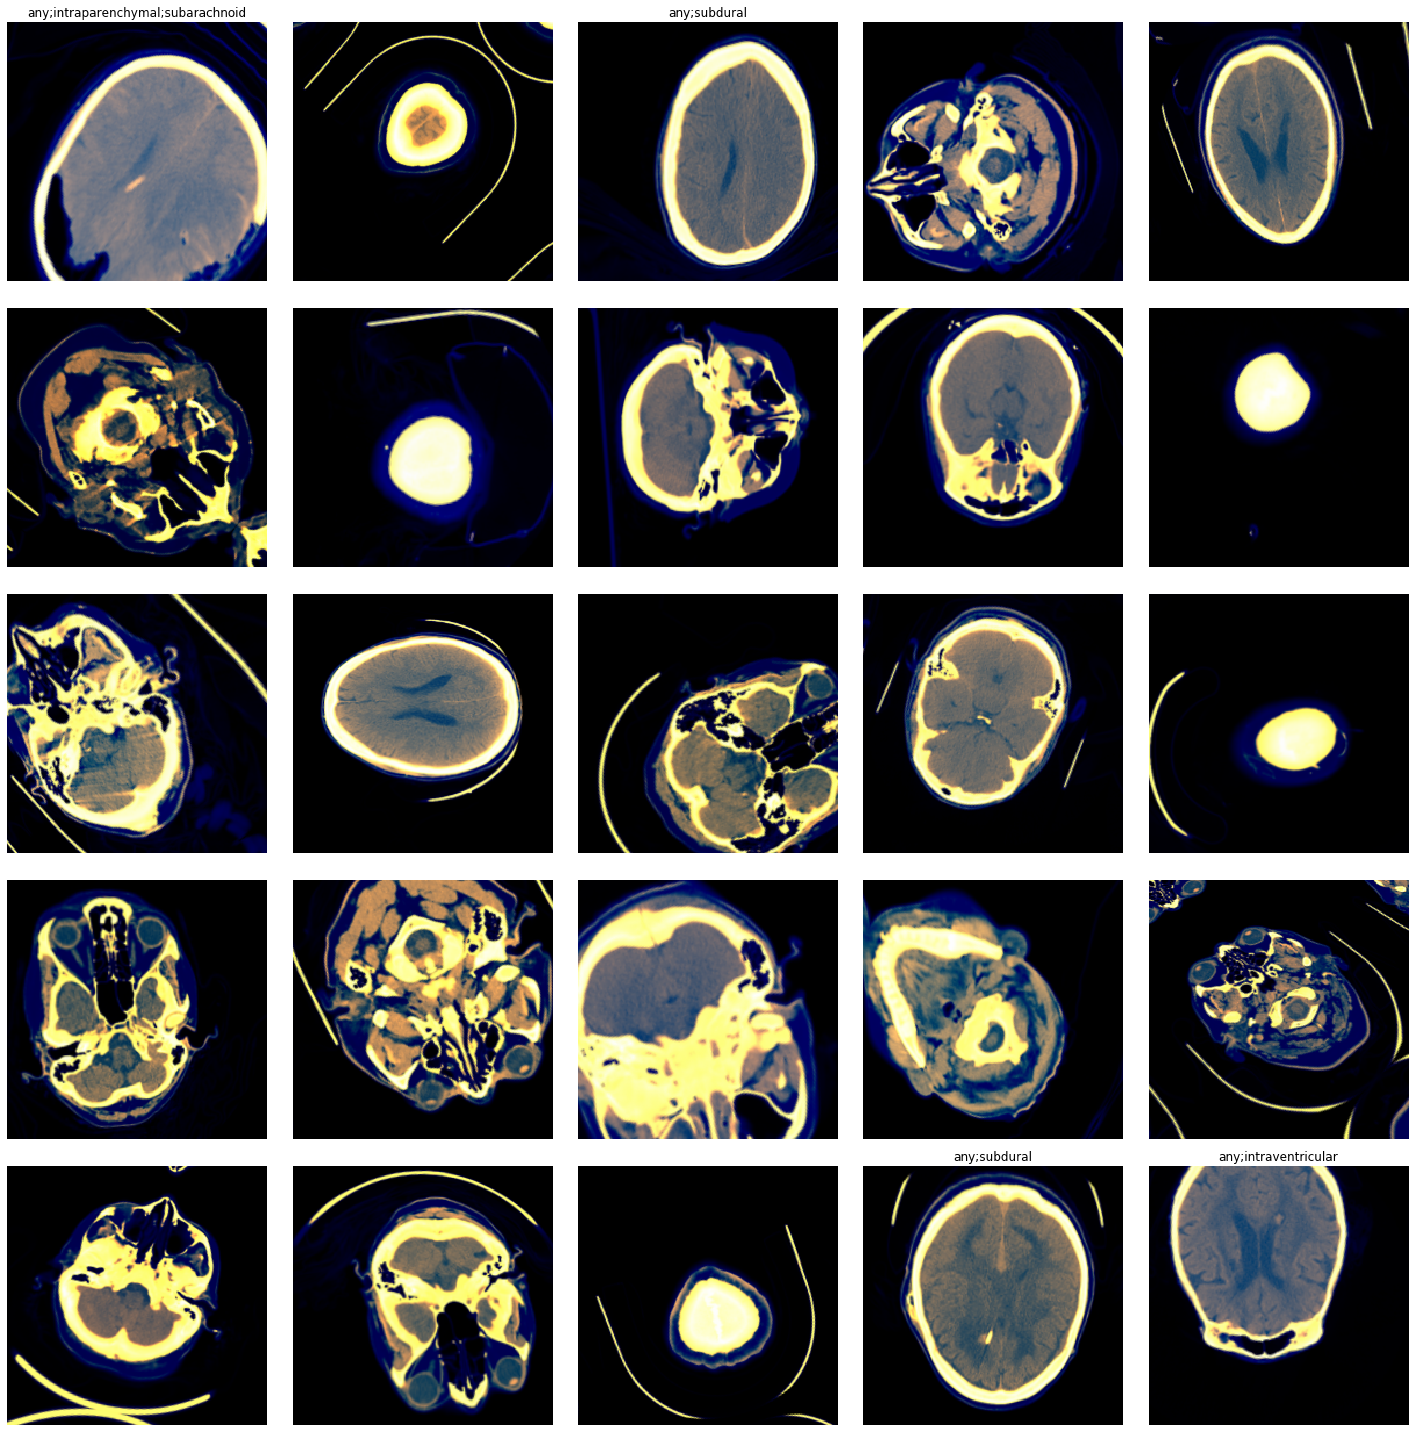

In [6]:
data.show_batch()

In [6]:
weights = torch.FloatTensor([0.28, 0.14, 0.14, 0.14, 0.14, 0.14]).cuda()
def my_loss(y_pred,y_true,weights=weights):
    return F.binary_cross_entropy_with_logits(y_pred, y_true,
                                  weights.repeat(y_pred.shape[0],1))

In [7]:
learn = cnn_learner(data,
                    models.densenet121,
                    wd=1e-3,
                    bn_wd=False, 
                    true_wd=True, 
                    opt_func=opt_func,
                    loss_func = my_loss,
                    metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()


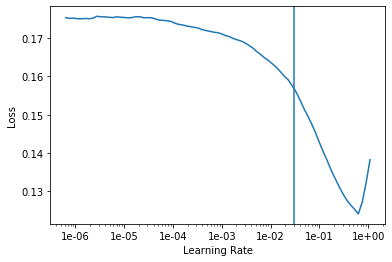

In [11]:
lr = 0.03
learn.recorder.plot()
plt.axvline(lr)

In [8]:
lr = 0.03
flattenAnneal(learn, lr, 50, 0.5)

epoch,train_loss,valid_loss,accuracy_thresh,time


RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.0.conv0.weight", "0.0.norm0.weight", "0.0.norm0.bias", "0.0.norm0.running_mean", "0.0.norm0.running_var", "0.0.denseblock1.denselayer1.norm1.weight", "0.0.denseblock1.denselayer1.norm1.bias", "0.0.denseblock1.denselayer1.norm1.running_mean", "0.0.denseblock1.denselayer1.norm1.running_var", "0.0.denseblock1.denselayer1.conv1.weight", "0.0.denseblock1.denselayer1.norm2.weight", "0.0.denseblock1.denselayer1.norm2.bias", "0.0.denseblock1.denselayer1.norm2.running_mean", "0.0.denseblock1.denselayer1.norm2.running_var", "0.0.denseblock1.denselayer1.conv2.weight", "0.0.denseblock1.denselayer2.norm1.weight", "0.0.denseblock1.denselayer2.norm1.bias", "0.0.denseblock1.denselayer2.norm1.running_mean", "0.0.denseblock1.denselayer2.norm1.running_var", "0.0.denseblock1.denselayer2.conv1.weight", "0.0.denseblock1.denselayer2.norm2.weight", "0.0.denseblock1.denselayer2.norm2.bias", "0.0.denseblock1.denselayer2.norm2.running_mean", "0.0.denseblock1.denselayer2.norm2.running_var", "0.0.denseblock1.denselayer2.conv2.weight", "0.0.denseblock1.denselayer3.norm1.weight", "0.0.denseblock1.denselayer3.norm1.bias", "0.0.denseblock1.denselayer3.norm1.running_mean", "0.0.denseblock1.denselayer3.norm1.running_var", "0.0.denseblock1.denselayer3.conv1.weight", "0.0.denseblock1.denselayer3.norm2.weight", "0.0.denseblock1.denselayer3.norm2.bias", "0.0.denseblock1.denselayer3.norm2.running_mean", "0.0.denseblock1.denselayer3.norm2.running_var", "0.0.denseblock1.denselayer3.conv2.weight", "0.0.denseblock1.denselayer4.norm1.weight", "0.0.denseblock1.denselayer4.norm1.bias", "0.0.denseblock1.denselayer4.norm1.running_mean", "0.0.denseblock1.denselayer4.norm1.running_var", "0.0.denseblock1.denselayer4.conv1.weight", "0.0.denseblock1.denselayer4.norm2.weight", "0.0.denseblock1.denselayer4.norm2.bias", "0.0.denseblock1.denselayer4.norm2.running_mean", "0.0.denseblock1.denselayer4.norm2.running_var", "0.0.denseblock1.denselayer4.conv2.weight", "0.0.denseblock1.denselayer5.norm1.weight", "0.0.denseblock1.denselayer5.norm1.bias", "0.0.denseblock1.denselayer5.norm1.running_mean", "0.0.denseblock1.denselayer5.norm1.running_var", "0.0.denseblock1.denselayer5.conv1.weight", "0.0.denseblock1.denselayer5.norm2.weight", "0.0.denseblock1.denselayer5.norm2.bias", "0.0.denseblock1.denselayer5.norm2.running_mean", "0.0.denseblock1.denselayer5.norm2.running_var", "0.0.denseblock1.denselayer5.conv2.weight", "0.0.denseblock1.denselayer6.norm1.weight", "0.0.denseblock1.denselayer6.norm1.bias", "0.0.denseblock1.denselayer6.norm1.running_mean", "0.0.denseblock1.denselayer6.norm1.running_var", "0.0.denseblock1.denselayer6.conv1.weight", "0.0.denseblock1.denselayer6.norm2.weight", "0.0.denseblock1.denselayer6.norm2.bias", "0.0.denseblock1.denselayer6.norm2.running_mean", "0.0.denseblock1.denselayer6.norm2.running_var", "0.0.denseblock1.denselayer6.conv2.weight", "0.0.transition1.norm.weight", "0.0.transition1.norm.bias", "0.0.transition1.norm.running_mean", "0.0.transition1.norm.running_var", "0.0.transition1.conv.weight", "0.0.denseblock2.denselayer1.norm1.weight", "0.0.denseblock2.denselayer1.norm1.bias", "0.0.denseblock2.denselayer1.norm1.running_mean", "0.0.denseblock2.denselayer1.norm1.running_var", "0.0.denseblock2.denselayer1.conv1.weight", "0.0.denseblock2.denselayer1.norm2.weight", "0.0.denseblock2.denselayer1.norm2.bias", "0.0.denseblock2.denselayer1.norm2.running_mean", "0.0.denseblock2.denselayer1.norm2.running_var", "0.0.denseblock2.denselayer1.conv2.weight", "0.0.denseblock2.denselayer2.norm1.weight", "0.0.denseblock2.denselayer2.norm1.bias", "0.0.denseblock2.denselayer2.norm1.running_mean", "0.0.denseblock2.denselayer2.norm1.running_var", "0.0.denseblock2.denselayer2.conv1.weight", "0.0.denseblock2.denselayer2.norm2.weight", "0.0.denseblock2.denselayer2.norm2.bias", "0.0.denseblock2.denselayer2.norm2.running_mean", "0.0.denseblock2.denselayer2.norm2.running_var", "0.0.denseblock2.denselayer2.conv2.weight", "0.0.denseblock2.denselayer3.norm1.weight", "0.0.denseblock2.denselayer3.norm1.bias", "0.0.denseblock2.denselayer3.norm1.running_mean", "0.0.denseblock2.denselayer3.norm1.running_var", "0.0.denseblock2.denselayer3.conv1.weight", "0.0.denseblock2.denselayer3.norm2.weight", "0.0.denseblock2.denselayer3.norm2.bias", "0.0.denseblock2.denselayer3.norm2.running_mean", "0.0.denseblock2.denselayer3.norm2.running_var", "0.0.denseblock2.denselayer3.conv2.weight", "0.0.denseblock2.denselayer4.norm1.weight", "0.0.denseblock2.denselayer4.norm1.bias", "0.0.denseblock2.denselayer4.norm1.running_mean", "0.0.denseblock2.denselayer4.norm1.running_var", "0.0.denseblock2.denselayer4.conv1.weight", "0.0.denseblock2.denselayer4.norm2.weight", "0.0.denseblock2.denselayer4.norm2.bias", "0.0.denseblock2.denselayer4.norm2.running_mean", "0.0.denseblock2.denselayer4.norm2.running_var", "0.0.denseblock2.denselayer4.conv2.weight", "0.0.denseblock2.denselayer5.norm1.weight", "0.0.denseblock2.denselayer5.norm1.bias", "0.0.denseblock2.denselayer5.norm1.running_mean", "0.0.denseblock2.denselayer5.norm1.running_var", "0.0.denseblock2.denselayer5.conv1.weight", "0.0.denseblock2.denselayer5.norm2.weight", "0.0.denseblock2.denselayer5.norm2.bias", "0.0.denseblock2.denselayer5.norm2.running_mean", "0.0.denseblock2.denselayer5.norm2.running_var", "0.0.denseblock2.denselayer5.conv2.weight", "0.0.denseblock2.denselayer6.norm1.weight", "0.0.denseblock2.denselayer6.norm1.bias", "0.0.denseblock2.denselayer6.norm1.running_mean", "0.0.denseblock2.denselayer6.norm1.running_var", "0.0.denseblock2.denselayer6.conv1.weight", "0.0.denseblock2.denselayer6.norm2.weight", "0.0.denseblock2.denselayer6.norm2.bias", "0.0.denseblock2.denselayer6.norm2.running_mean", "0.0.denseblock2.denselayer6.norm2.running_var", "0.0.denseblock2.denselayer6.conv2.weight", "0.0.denseblock2.denselayer7.norm1.weight", "0.0.denseblock2.denselayer7.norm1.bias", "0.0.denseblock2.denselayer7.norm1.running_mean", "0.0.denseblock2.denselayer7.norm1.running_var", "0.0.denseblock2.denselayer7.conv1.weight", "0.0.denseblock2.denselayer7.norm2.weight", "0.0.denseblock2.denselayer7.norm2.bias", "0.0.denseblock2.denselayer7.norm2.running_mean", "0.0.denseblock2.denselayer7.norm2.running_var", "0.0.denseblock2.denselayer7.conv2.weight", "0.0.denseblock2.denselayer8.norm1.weight", "0.0.denseblock2.denselayer8.norm1.bias", "0.0.denseblock2.denselayer8.norm1.running_mean", "0.0.denseblock2.denselayer8.norm1.running_var", "0.0.denseblock2.denselayer8.conv1.weight", "0.0.denseblock2.denselayer8.norm2.weight", "0.0.denseblock2.denselayer8.norm2.bias", "0.0.denseblock2.denselayer8.norm2.running_mean", "0.0.denseblock2.denselayer8.norm2.running_var", "0.0.denseblock2.denselayer8.conv2.weight", "0.0.denseblock2.denselayer9.norm1.weight", "0.0.denseblock2.denselayer9.norm1.bias", "0.0.denseblock2.denselayer9.norm1.running_mean", "0.0.denseblock2.denselayer9.norm1.running_var", "0.0.denseblock2.denselayer9.conv1.weight", "0.0.denseblock2.denselayer9.norm2.weight", "0.0.denseblock2.denselayer9.norm2.bias", "0.0.denseblock2.denselayer9.norm2.running_mean", "0.0.denseblock2.denselayer9.norm2.running_var", "0.0.denseblock2.denselayer9.conv2.weight", "0.0.denseblock2.denselayer10.norm1.weight", "0.0.denseblock2.denselayer10.norm1.bias", "0.0.denseblock2.denselayer10.norm1.running_mean", "0.0.denseblock2.denselayer10.norm1.running_var", "0.0.denseblock2.denselayer10.conv1.weight", "0.0.denseblock2.denselayer10.norm2.weight", "0.0.denseblock2.denselayer10.norm2.bias", "0.0.denseblock2.denselayer10.norm2.running_mean", "0.0.denseblock2.denselayer10.norm2.running_var", "0.0.denseblock2.denselayer10.conv2.weight", "0.0.denseblock2.denselayer11.norm1.weight", "0.0.denseblock2.denselayer11.norm1.bias", "0.0.denseblock2.denselayer11.norm1.running_mean", "0.0.denseblock2.denselayer11.norm1.running_var", "0.0.denseblock2.denselayer11.conv1.weight", "0.0.denseblock2.denselayer11.norm2.weight", "0.0.denseblock2.denselayer11.norm2.bias", "0.0.denseblock2.denselayer11.norm2.running_mean", "0.0.denseblock2.denselayer11.norm2.running_var", "0.0.denseblock2.denselayer11.conv2.weight", "0.0.denseblock2.denselayer12.norm1.weight", "0.0.denseblock2.denselayer12.norm1.bias", "0.0.denseblock2.denselayer12.norm1.running_mean", "0.0.denseblock2.denselayer12.norm1.running_var", "0.0.denseblock2.denselayer12.conv1.weight", "0.0.denseblock2.denselayer12.norm2.weight", "0.0.denseblock2.denselayer12.norm2.bias", "0.0.denseblock2.denselayer12.norm2.running_mean", "0.0.denseblock2.denselayer12.norm2.running_var", "0.0.denseblock2.denselayer12.conv2.weight", "0.0.transition2.norm.weight", "0.0.transition2.norm.bias", "0.0.transition2.norm.running_mean", "0.0.transition2.norm.running_var", "0.0.transition2.conv.weight", "0.0.denseblock3.denselayer1.norm1.weight", "0.0.denseblock3.denselayer1.norm1.bias", "0.0.denseblock3.denselayer1.norm1.running_mean", "0.0.denseblock3.denselayer1.norm1.running_var", "0.0.denseblock3.denselayer1.conv1.weight", "0.0.denseblock3.denselayer1.norm2.weight", "0.0.denseblock3.denselayer1.norm2.bias", "0.0.denseblock3.denselayer1.norm2.running_mean", "0.0.denseblock3.denselayer1.norm2.running_var", "0.0.denseblock3.denselayer1.conv2.weight", "0.0.denseblock3.denselayer2.norm1.weight", "0.0.denseblock3.denselayer2.norm1.bias", "0.0.denseblock3.denselayer2.norm1.running_mean", "0.0.denseblock3.denselayer2.norm1.running_var", "0.0.denseblock3.denselayer2.conv1.weight", "0.0.denseblock3.denselayer2.norm2.weight", "0.0.denseblock3.denselayer2.norm2.bias", "0.0.denseblock3.denselayer2.norm2.running_mean", "0.0.denseblock3.denselayer2.norm2.running_var", "0.0.denseblock3.denselayer2.conv2.weight", "0.0.denseblock3.denselayer3.norm1.weight", "0.0.denseblock3.denselayer3.norm1.bias", "0.0.denseblock3.denselayer3.norm1.running_mean", "0.0.denseblock3.denselayer3.norm1.running_var", "0.0.denseblock3.denselayer3.conv1.weight", "0.0.denseblock3.denselayer3.norm2.weight", "0.0.denseblock3.denselayer3.norm2.bias", "0.0.denseblock3.denselayer3.norm2.running_mean", "0.0.denseblock3.denselayer3.norm2.running_var", "0.0.denseblock3.denselayer3.conv2.weight", "0.0.denseblock3.denselayer4.norm1.weight", "0.0.denseblock3.denselayer4.norm1.bias", "0.0.denseblock3.denselayer4.norm1.running_mean", "0.0.denseblock3.denselayer4.norm1.running_var", "0.0.denseblock3.denselayer4.conv1.weight", "0.0.denseblock3.denselayer4.norm2.weight", "0.0.denseblock3.denselayer4.norm2.bias", "0.0.denseblock3.denselayer4.norm2.running_mean", "0.0.denseblock3.denselayer4.norm2.running_var", "0.0.denseblock3.denselayer4.conv2.weight", "0.0.denseblock3.denselayer5.norm1.weight", "0.0.denseblock3.denselayer5.norm1.bias", "0.0.denseblock3.denselayer5.norm1.running_mean", "0.0.denseblock3.denselayer5.norm1.running_var", "0.0.denseblock3.denselayer5.conv1.weight", "0.0.denseblock3.denselayer5.norm2.weight", "0.0.denseblock3.denselayer5.norm2.bias", "0.0.denseblock3.denselayer5.norm2.running_mean", "0.0.denseblock3.denselayer5.norm2.running_var", "0.0.denseblock3.denselayer5.conv2.weight", "0.0.denseblock3.denselayer6.norm1.weight", "0.0.denseblock3.denselayer6.norm1.bias", "0.0.denseblock3.denselayer6.norm1.running_mean", "0.0.denseblock3.denselayer6.norm1.running_var", "0.0.denseblock3.denselayer6.conv1.weight", "0.0.denseblock3.denselayer6.norm2.weight", "0.0.denseblock3.denselayer6.norm2.bias", "0.0.denseblock3.denselayer6.norm2.running_mean", "0.0.denseblock3.denselayer6.norm2.running_var", "0.0.denseblock3.denselayer6.conv2.weight", "0.0.denseblock3.denselayer7.norm1.weight", "0.0.denseblock3.denselayer7.norm1.bias", "0.0.denseblock3.denselayer7.norm1.running_mean", "0.0.denseblock3.denselayer7.norm1.running_var", "0.0.denseblock3.denselayer7.conv1.weight", "0.0.denseblock3.denselayer7.norm2.weight", "0.0.denseblock3.denselayer7.norm2.bias", "0.0.denseblock3.denselayer7.norm2.running_mean", "0.0.denseblock3.denselayer7.norm2.running_var", "0.0.denseblock3.denselayer7.conv2.weight", "0.0.denseblock3.denselayer8.norm1.weight", "0.0.denseblock3.denselayer8.norm1.bias", "0.0.denseblock3.denselayer8.norm1.running_mean", "0.0.denseblock3.denselayer8.norm1.running_var", "0.0.denseblock3.denselayer8.conv1.weight", "0.0.denseblock3.denselayer8.norm2.weight", "0.0.denseblock3.denselayer8.norm2.bias", "0.0.denseblock3.denselayer8.norm2.running_mean", "0.0.denseblock3.denselayer8.norm2.running_var", "0.0.denseblock3.denselayer8.conv2.weight", "0.0.denseblock3.denselayer9.norm1.weight", "0.0.denseblock3.denselayer9.norm1.bias", "0.0.denseblock3.denselayer9.norm1.running_mean", "0.0.denseblock3.denselayer9.norm1.running_var", "0.0.denseblock3.denselayer9.conv1.weight", "0.0.denseblock3.denselayer9.norm2.weight", "0.0.denseblock3.denselayer9.norm2.bias", "0.0.denseblock3.denselayer9.norm2.running_mean", "0.0.denseblock3.denselayer9.norm2.running_var", "0.0.denseblock3.denselayer9.conv2.weight", "0.0.denseblock3.denselayer10.norm1.weight", "0.0.denseblock3.denselayer10.norm1.bias", "0.0.denseblock3.denselayer10.norm1.running_mean", "0.0.denseblock3.denselayer10.norm1.running_var", "0.0.denseblock3.denselayer10.conv1.weight", "0.0.denseblock3.denselayer10.norm2.weight", "0.0.denseblock3.denselayer10.norm2.bias", "0.0.denseblock3.denselayer10.norm2.running_mean", "0.0.denseblock3.denselayer10.norm2.running_var", "0.0.denseblock3.denselayer10.conv2.weight", "0.0.denseblock3.denselayer11.norm1.weight", "0.0.denseblock3.denselayer11.norm1.bias", "0.0.denseblock3.denselayer11.norm1.running_mean", "0.0.denseblock3.denselayer11.norm1.running_var", "0.0.denseblock3.denselayer11.conv1.weight", "0.0.denseblock3.denselayer11.norm2.weight", "0.0.denseblock3.denselayer11.norm2.bias", "0.0.denseblock3.denselayer11.norm2.running_mean", "0.0.denseblock3.denselayer11.norm2.running_var", "0.0.denseblock3.denselayer11.conv2.weight", "0.0.denseblock3.denselayer12.norm1.weight", "0.0.denseblock3.denselayer12.norm1.bias", "0.0.denseblock3.denselayer12.norm1.running_mean", "0.0.denseblock3.denselayer12.norm1.running_var", "0.0.denseblock3.denselayer12.conv1.weight", "0.0.denseblock3.denselayer12.norm2.weight", "0.0.denseblock3.denselayer12.norm2.bias", "0.0.denseblock3.denselayer12.norm2.running_mean", "0.0.denseblock3.denselayer12.norm2.running_var", "0.0.denseblock3.denselayer12.conv2.weight", "0.0.denseblock3.denselayer13.norm1.weight", "0.0.denseblock3.denselayer13.norm1.bias", "0.0.denseblock3.denselayer13.norm1.running_mean", "0.0.denseblock3.denselayer13.norm1.running_var", "0.0.denseblock3.denselayer13.conv1.weight", "0.0.denseblock3.denselayer13.norm2.weight", "0.0.denseblock3.denselayer13.norm2.bias", "0.0.denseblock3.denselayer13.norm2.running_mean", "0.0.denseblock3.denselayer13.norm2.running_var", "0.0.denseblock3.denselayer13.conv2.weight", "0.0.denseblock3.denselayer14.norm1.weight", "0.0.denseblock3.denselayer14.norm1.bias", "0.0.denseblock3.denselayer14.norm1.running_mean", "0.0.denseblock3.denselayer14.norm1.running_var", "0.0.denseblock3.denselayer14.conv1.weight", "0.0.denseblock3.denselayer14.norm2.weight", "0.0.denseblock3.denselayer14.norm2.bias", "0.0.denseblock3.denselayer14.norm2.running_mean", "0.0.denseblock3.denselayer14.norm2.running_var", "0.0.denseblock3.denselayer14.conv2.weight", "0.0.denseblock3.denselayer15.norm1.weight", "0.0.denseblock3.denselayer15.norm1.bias", "0.0.denseblock3.denselayer15.norm1.running_mean", "0.0.denseblock3.denselayer15.norm1.running_var", "0.0.denseblock3.denselayer15.conv1.weight", "0.0.denseblock3.denselayer15.norm2.weight", "0.0.denseblock3.denselayer15.norm2.bias", "0.0.denseblock3.denselayer15.norm2.running_mean", "0.0.denseblock3.denselayer15.norm2.running_var", "0.0.denseblock3.denselayer15.conv2.weight", "0.0.denseblock3.denselayer16.norm1.weight", "0.0.denseblock3.denselayer16.norm1.bias", "0.0.denseblock3.denselayer16.norm1.running_mean", "0.0.denseblock3.denselayer16.norm1.running_var", "0.0.denseblock3.denselayer16.conv1.weight", "0.0.denseblock3.denselayer16.norm2.weight", "0.0.denseblock3.denselayer16.norm2.bias", "0.0.denseblock3.denselayer16.norm2.running_mean", "0.0.denseblock3.denselayer16.norm2.running_var", "0.0.denseblock3.denselayer16.conv2.weight", "0.0.denseblock3.denselayer17.norm1.weight", "0.0.denseblock3.denselayer17.norm1.bias", "0.0.denseblock3.denselayer17.norm1.running_mean", "0.0.denseblock3.denselayer17.norm1.running_var", "0.0.denseblock3.denselayer17.conv1.weight", "0.0.denseblock3.denselayer17.norm2.weight", "0.0.denseblock3.denselayer17.norm2.bias", "0.0.denseblock3.denselayer17.norm2.running_mean", "0.0.denseblock3.denselayer17.norm2.running_var", "0.0.denseblock3.denselayer17.conv2.weight", "0.0.denseblock3.denselayer18.norm1.weight", "0.0.denseblock3.denselayer18.norm1.bias", "0.0.denseblock3.denselayer18.norm1.running_mean", "0.0.denseblock3.denselayer18.norm1.running_var", "0.0.denseblock3.denselayer18.conv1.weight", "0.0.denseblock3.denselayer18.norm2.weight", "0.0.denseblock3.denselayer18.norm2.bias", "0.0.denseblock3.denselayer18.norm2.running_mean", "0.0.denseblock3.denselayer18.norm2.running_var", "0.0.denseblock3.denselayer18.conv2.weight", "0.0.denseblock3.denselayer19.norm1.weight", "0.0.denseblock3.denselayer19.norm1.bias", "0.0.denseblock3.denselayer19.norm1.running_mean", "0.0.denseblock3.denselayer19.norm1.running_var", "0.0.denseblock3.denselayer19.conv1.weight", "0.0.denseblock3.denselayer19.norm2.weight", "0.0.denseblock3.denselayer19.norm2.bias", "0.0.denseblock3.denselayer19.norm2.running_mean", "0.0.denseblock3.denselayer19.norm2.running_var", "0.0.denseblock3.denselayer19.conv2.weight", "0.0.denseblock3.denselayer20.norm1.weight", "0.0.denseblock3.denselayer20.norm1.bias", "0.0.denseblock3.denselayer20.norm1.running_mean", "0.0.denseblock3.denselayer20.norm1.running_var", "0.0.denseblock3.denselayer20.conv1.weight", "0.0.denseblock3.denselayer20.norm2.weight", "0.0.denseblock3.denselayer20.norm2.bias", "0.0.denseblock3.denselayer20.norm2.running_mean", "0.0.denseblock3.denselayer20.norm2.running_var", "0.0.denseblock3.denselayer20.conv2.weight", "0.0.denseblock3.denselayer21.norm1.weight", "0.0.denseblock3.denselayer21.norm1.bias", "0.0.denseblock3.denselayer21.norm1.running_mean", "0.0.denseblock3.denselayer21.norm1.running_var", "0.0.denseblock3.denselayer21.conv1.weight", "0.0.denseblock3.denselayer21.norm2.weight", "0.0.denseblock3.denselayer21.norm2.bias", "0.0.denseblock3.denselayer21.norm2.running_mean", "0.0.denseblock3.denselayer21.norm2.running_var", "0.0.denseblock3.denselayer21.conv2.weight", "0.0.denseblock3.denselayer22.norm1.weight", "0.0.denseblock3.denselayer22.norm1.bias", "0.0.denseblock3.denselayer22.norm1.running_mean", "0.0.denseblock3.denselayer22.norm1.running_var", "0.0.denseblock3.denselayer22.conv1.weight", "0.0.denseblock3.denselayer22.norm2.weight", "0.0.denseblock3.denselayer22.norm2.bias", "0.0.denseblock3.denselayer22.norm2.running_mean", "0.0.denseblock3.denselayer22.norm2.running_var", "0.0.denseblock3.denselayer22.conv2.weight", "0.0.denseblock3.denselayer23.norm1.weight", "0.0.denseblock3.denselayer23.norm1.bias", "0.0.denseblock3.denselayer23.norm1.running_mean", "0.0.denseblock3.denselayer23.norm1.running_var", "0.0.denseblock3.denselayer23.conv1.weight", "0.0.denseblock3.denselayer23.norm2.weight", "0.0.denseblock3.denselayer23.norm2.bias", "0.0.denseblock3.denselayer23.norm2.running_mean", "0.0.denseblock3.denselayer23.norm2.running_var", "0.0.denseblock3.denselayer23.conv2.weight", "0.0.denseblock3.denselayer24.norm1.weight", "0.0.denseblock3.denselayer24.norm1.bias", "0.0.denseblock3.denselayer24.norm1.running_mean", "0.0.denseblock3.denselayer24.norm1.running_var", "0.0.denseblock3.denselayer24.conv1.weight", "0.0.denseblock3.denselayer24.norm2.weight", "0.0.denseblock3.denselayer24.norm2.bias", "0.0.denseblock3.denselayer24.norm2.running_mean", "0.0.denseblock3.denselayer24.norm2.running_var", "0.0.denseblock3.denselayer24.conv2.weight", "0.0.transition3.norm.weight", "0.0.transition3.norm.bias", "0.0.transition3.norm.running_mean", "0.0.transition3.norm.running_var", "0.0.transition3.conv.weight", "0.0.denseblock4.denselayer1.norm1.weight", "0.0.denseblock4.denselayer1.norm1.bias", "0.0.denseblock4.denselayer1.norm1.running_mean", "0.0.denseblock4.denselayer1.norm1.running_var", "0.0.denseblock4.denselayer1.conv1.weight", "0.0.denseblock4.denselayer1.norm2.weight", "0.0.denseblock4.denselayer1.norm2.bias", "0.0.denseblock4.denselayer1.norm2.running_mean", "0.0.denseblock4.denselayer1.norm2.running_var", "0.0.denseblock4.denselayer1.conv2.weight", "0.0.denseblock4.denselayer2.norm1.weight", "0.0.denseblock4.denselayer2.norm1.bias", "0.0.denseblock4.denselayer2.norm1.running_mean", "0.0.denseblock4.denselayer2.norm1.running_var", "0.0.denseblock4.denselayer2.conv1.weight", "0.0.denseblock4.denselayer2.norm2.weight", "0.0.denseblock4.denselayer2.norm2.bias", "0.0.denseblock4.denselayer2.norm2.running_mean", "0.0.denseblock4.denselayer2.norm2.running_var", "0.0.denseblock4.denselayer2.conv2.weight", "0.0.denseblock4.denselayer3.norm1.weight", "0.0.denseblock4.denselayer3.norm1.bias", "0.0.denseblock4.denselayer3.norm1.running_mean", "0.0.denseblock4.denselayer3.norm1.running_var", "0.0.denseblock4.denselayer3.conv1.weight", "0.0.denseblock4.denselayer3.norm2.weight", "0.0.denseblock4.denselayer3.norm2.bias", "0.0.denseblock4.denselayer3.norm2.running_mean", "0.0.denseblock4.denselayer3.norm2.running_var", "0.0.denseblock4.denselayer3.conv2.weight", "0.0.denseblock4.denselayer4.norm1.weight", "0.0.denseblock4.denselayer4.norm1.bias", "0.0.denseblock4.denselayer4.norm1.running_mean", "0.0.denseblock4.denselayer4.norm1.running_var", "0.0.denseblock4.denselayer4.conv1.weight", "0.0.denseblock4.denselayer4.norm2.weight", "0.0.denseblock4.denselayer4.norm2.bias", "0.0.denseblock4.denselayer4.norm2.running_mean", "0.0.denseblock4.denselayer4.norm2.running_var", "0.0.denseblock4.denselayer4.conv2.weight", "0.0.denseblock4.denselayer5.norm1.weight", "0.0.denseblock4.denselayer5.norm1.bias", "0.0.denseblock4.denselayer5.norm1.running_mean", "0.0.denseblock4.denselayer5.norm1.running_var", "0.0.denseblock4.denselayer5.conv1.weight", "0.0.denseblock4.denselayer5.norm2.weight", "0.0.denseblock4.denselayer5.norm2.bias", "0.0.denseblock4.denselayer5.norm2.running_mean", "0.0.denseblock4.denselayer5.norm2.running_var", "0.0.denseblock4.denselayer5.conv2.weight", "0.0.denseblock4.denselayer6.norm1.weight", "0.0.denseblock4.denselayer6.norm1.bias", "0.0.denseblock4.denselayer6.norm1.running_mean", "0.0.denseblock4.denselayer6.norm1.running_var", "0.0.denseblock4.denselayer6.conv1.weight", "0.0.denseblock4.denselayer6.norm2.weight", "0.0.denseblock4.denselayer6.norm2.bias", "0.0.denseblock4.denselayer6.norm2.running_mean", "0.0.denseblock4.denselayer6.norm2.running_var", "0.0.denseblock4.denselayer6.conv2.weight", "0.0.denseblock4.denselayer7.norm1.weight", "0.0.denseblock4.denselayer7.norm1.bias", "0.0.denseblock4.denselayer7.norm1.running_mean", "0.0.denseblock4.denselayer7.norm1.running_var", "0.0.denseblock4.denselayer7.conv1.weight", "0.0.denseblock4.denselayer7.norm2.weight", "0.0.denseblock4.denselayer7.norm2.bias", "0.0.denseblock4.denselayer7.norm2.running_mean", "0.0.denseblock4.denselayer7.norm2.running_var", "0.0.denseblock4.denselayer7.conv2.weight", "0.0.denseblock4.denselayer8.norm1.weight", "0.0.denseblock4.denselayer8.norm1.bias", "0.0.denseblock4.denselayer8.norm1.running_mean", "0.0.denseblock4.denselayer8.norm1.running_var", "0.0.denseblock4.denselayer8.conv1.weight", "0.0.denseblock4.denselayer8.norm2.weight", "0.0.denseblock4.denselayer8.norm2.bias", "0.0.denseblock4.denselayer8.norm2.running_mean", "0.0.denseblock4.denselayer8.norm2.running_var", "0.0.denseblock4.denselayer8.conv2.weight", "0.0.denseblock4.denselayer9.norm1.weight", "0.0.denseblock4.denselayer9.norm1.bias", "0.0.denseblock4.denselayer9.norm1.running_mean", "0.0.denseblock4.denselayer9.norm1.running_var", "0.0.denseblock4.denselayer9.conv1.weight", "0.0.denseblock4.denselayer9.norm2.weight", "0.0.denseblock4.denselayer9.norm2.bias", "0.0.denseblock4.denselayer9.norm2.running_mean", "0.0.denseblock4.denselayer9.norm2.running_var", "0.0.denseblock4.denselayer9.conv2.weight", "0.0.denseblock4.denselayer10.norm1.weight", "0.0.denseblock4.denselayer10.norm1.bias", "0.0.denseblock4.denselayer10.norm1.running_mean", "0.0.denseblock4.denselayer10.norm1.running_var", "0.0.denseblock4.denselayer10.conv1.weight", "0.0.denseblock4.denselayer10.norm2.weight", "0.0.denseblock4.denselayer10.norm2.bias", "0.0.denseblock4.denselayer10.norm2.running_mean", "0.0.denseblock4.denselayer10.norm2.running_var", "0.0.denseblock4.denselayer10.conv2.weight", "0.0.denseblock4.denselayer11.norm1.weight", "0.0.denseblock4.denselayer11.norm1.bias", "0.0.denseblock4.denselayer11.norm1.running_mean", "0.0.denseblock4.denselayer11.norm1.running_var", "0.0.denseblock4.denselayer11.conv1.weight", "0.0.denseblock4.denselayer11.norm2.weight", "0.0.denseblock4.denselayer11.norm2.bias", "0.0.denseblock4.denselayer11.norm2.running_mean", "0.0.denseblock4.denselayer11.norm2.running_var", "0.0.denseblock4.denselayer11.conv2.weight", "0.0.denseblock4.denselayer12.norm1.weight", "0.0.denseblock4.denselayer12.norm1.bias", "0.0.denseblock4.denselayer12.norm1.running_mean", "0.0.denseblock4.denselayer12.norm1.running_var", "0.0.denseblock4.denselayer12.conv1.weight", "0.0.denseblock4.denselayer12.norm2.weight", "0.0.denseblock4.denselayer12.norm2.bias", "0.0.denseblock4.denselayer12.norm2.running_mean", "0.0.denseblock4.denselayer12.norm2.running_var", "0.0.denseblock4.denselayer12.conv2.weight", "0.0.denseblock4.denselayer13.norm1.weight", "0.0.denseblock4.denselayer13.norm1.bias", "0.0.denseblock4.denselayer13.norm1.running_mean", "0.0.denseblock4.denselayer13.norm1.running_var", "0.0.denseblock4.denselayer13.conv1.weight", "0.0.denseblock4.denselayer13.norm2.weight", "0.0.denseblock4.denselayer13.norm2.bias", "0.0.denseblock4.denselayer13.norm2.running_mean", "0.0.denseblock4.denselayer13.norm2.running_var", "0.0.denseblock4.denselayer13.conv2.weight", "0.0.denseblock4.denselayer14.norm1.weight", "0.0.denseblock4.denselayer14.norm1.bias", "0.0.denseblock4.denselayer14.norm1.running_mean", "0.0.denseblock4.denselayer14.norm1.running_var", "0.0.denseblock4.denselayer14.conv1.weight", "0.0.denseblock4.denselayer14.norm2.weight", "0.0.denseblock4.denselayer14.norm2.bias", "0.0.denseblock4.denselayer14.norm2.running_mean", "0.0.denseblock4.denselayer14.norm2.running_var", "0.0.denseblock4.denselayer14.conv2.weight", "0.0.denseblock4.denselayer15.norm1.weight", "0.0.denseblock4.denselayer15.norm1.bias", "0.0.denseblock4.denselayer15.norm1.running_mean", "0.0.denseblock4.denselayer15.norm1.running_var", "0.0.denseblock4.denselayer15.conv1.weight", "0.0.denseblock4.denselayer15.norm2.weight", "0.0.denseblock4.denselayer15.norm2.bias", "0.0.denseblock4.denselayer15.norm2.running_mean", "0.0.denseblock4.denselayer15.norm2.running_var", "0.0.denseblock4.denselayer15.conv2.weight", "0.0.denseblock4.denselayer16.norm1.weight", "0.0.denseblock4.denselayer16.norm1.bias", "0.0.denseblock4.denselayer16.norm1.running_mean", "0.0.denseblock4.denselayer16.norm1.running_var", "0.0.denseblock4.denselayer16.conv1.weight", "0.0.denseblock4.denselayer16.norm2.weight", "0.0.denseblock4.denselayer16.norm2.bias", "0.0.denseblock4.denselayer16.norm2.running_mean", "0.0.denseblock4.denselayer16.norm2.running_var", "0.0.denseblock4.denselayer16.conv2.weight", "0.0.norm5.weight", "0.0.norm5.bias", "0.0.norm5.running_mean", "0.0.norm5.running_var", "1.2.weight", "1.2.bias", "1.2.running_mean", "1.2.running_var", "1.4.weight", "1.4.bias", "1.6.weight", "1.6.bias", "1.6.running_mean", "1.6.running_var", "1.8.weight", "1.8.bias". 
	Unexpected key(s) in state_dict: "conv1.0.weight", "conv1.2.weight", "conv1.2.bias", "conv1.2.running_mean", "conv1.2.running_var", "conv1.2.num_batches_tracked", "conv2.0.weight", "conv2.2.weight", "conv2.2.bias", "conv2.2.running_mean", "conv2.2.running_var", "conv2.2.num_batches_tracked", "conv3.0.weight", "conv3.2.weight", "conv3.2.bias", "conv3.2.running_mean", "conv3.2.running_var", "conv3.2.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.convs.0.weight", "layer1.0.convs.1.weight", "layer1.0.convs.2.weight", "layer1.0.bns.0.weight", "layer1.0.bns.0.bias", "layer1.0.bns.0.running_mean", "layer1.0.bns.0.running_var", "layer1.0.bns.0.num_batches_tracked", "layer1.0.bns.1.weight", "layer1.0.bns.1.bias", "layer1.0.bns.1.running_mean", "layer1.0.bns.1.running_var", "layer1.0.bns.1.num_batches_tracked", "layer1.0.bns.2.weight", "layer1.0.bns.2.bias", "layer1.0.bns.2.running_mean", "layer1.0.bns.2.running_var", "layer1.0.bns.2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.convs.0.weight", "layer1.1.convs.1.weight", "layer1.1.convs.2.weight", "layer1.1.bns.0.weight", "layer1.1.bns.0.bias", "layer1.1.bns.0.running_mean", "layer1.1.bns.0.running_var", "layer1.1.bns.0.num_batches_tracked", "layer1.1.bns.1.weight", "layer1.1.bns.1.bias", "layer1.1.bns.1.running_mean", "layer1.1.bns.1.running_var", "layer1.1.bns.1.num_batches_tracked", "layer1.1.bns.2.weight", "layer1.1.bns.2.bias", "layer1.1.bns.2.running_mean", "layer1.1.bns.2.running_var", "layer1.1.bns.2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.convs.0.weight", "layer1.2.convs.1.weight", "layer1.2.convs.2.weight", "layer1.2.bns.0.weight", "layer1.2.bns.0.bias", "layer1.2.bns.0.running_mean", "layer1.2.bns.0.running_var", "layer1.2.bns.0.num_batches_tracked", "layer1.2.bns.1.weight", "layer1.2.bns.1.bias", "layer1.2.bns.1.running_mean", "layer1.2.bns.1.running_var", "layer1.2.bns.1.num_batches_tracked", "layer1.2.bns.2.weight", "layer1.2.bns.2.bias", "layer1.2.bns.2.running_mean", "layer1.2.bns.2.running_var", "layer1.2.bns.2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.convs.0.weight", "layer2.0.convs.1.weight", "layer2.0.convs.2.weight", "layer2.0.bns.0.weight", "layer2.0.bns.0.bias", "layer2.0.bns.0.running_mean", "layer2.0.bns.0.running_var", "layer2.0.bns.0.num_batches_tracked", "layer2.0.bns.1.weight", "layer2.0.bns.1.bias", "layer2.0.bns.1.running_mean", "layer2.0.bns.1.running_var", "layer2.0.bns.1.num_batches_tracked", "layer2.0.bns.2.weight", "layer2.0.bns.2.bias", "layer2.0.bns.2.running_mean", "layer2.0.bns.2.running_var", "layer2.0.bns.2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.convs.0.weight", "layer2.1.convs.1.weight", "layer2.1.convs.2.weight", "layer2.1.bns.0.weight", "layer2.1.bns.0.bias", "layer2.1.bns.0.running_mean", "layer2.1.bns.0.running_var", "layer2.1.bns.0.num_batches_tracked", "layer2.1.bns.1.weight", "layer2.1.bns.1.bias", "layer2.1.bns.1.running_mean", "layer2.1.bns.1.running_var", "layer2.1.bns.1.num_batches_tracked", "layer2.1.bns.2.weight", "layer2.1.bns.2.bias", "layer2.1.bns.2.running_mean", "layer2.1.bns.2.running_var", "layer2.1.bns.2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.convs.0.weight", "layer2.2.convs.1.weight", "layer2.2.convs.2.weight", "layer2.2.bns.0.weight", "layer2.2.bns.0.bias", "layer2.2.bns.0.running_mean", "layer2.2.bns.0.running_var", "layer2.2.bns.0.num_batches_tracked", "layer2.2.bns.1.weight", "layer2.2.bns.1.bias", "layer2.2.bns.1.running_mean", "layer2.2.bns.1.running_var", "layer2.2.bns.1.num_batches_tracked", "layer2.2.bns.2.weight", "layer2.2.bns.2.bias", "layer2.2.bns.2.running_mean", "layer2.2.bns.2.running_var", "layer2.2.bns.2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.convs.0.weight", "layer2.3.convs.1.weight", "layer2.3.convs.2.weight", "layer2.3.bns.0.weight", "layer2.3.bns.0.bias", "layer2.3.bns.0.running_mean", "layer2.3.bns.0.running_var", "layer2.3.bns.0.num_batches_tracked", "layer2.3.bns.1.weight", "layer2.3.bns.1.bias", "layer2.3.bns.1.running_mean", "layer2.3.bns.1.running_var", "layer2.3.bns.1.num_batches_tracked", "layer2.3.bns.2.weight", "layer2.3.bns.2.bias", "layer2.3.bns.2.running_mean", "layer2.3.bns.2.running_var", "layer2.3.bns.2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.convs.0.weight", "layer3.0.convs.1.weight", "layer3.0.convs.2.weight", "layer3.0.bns.0.weight", "layer3.0.bns.0.bias", "layer3.0.bns.0.running_mean", "layer3.0.bns.0.running_var", "layer3.0.bns.0.num_batches_tracked", "layer3.0.bns.1.weight", "layer3.0.bns.1.bias", "layer3.0.bns.1.running_mean", "layer3.0.bns.1.running_var", "layer3.0.bns.1.num_batches_tracked", "layer3.0.bns.2.weight", "layer3.0.bns.2.bias", "layer3.0.bns.2.running_mean", "layer3.0.bns.2.running_var", "layer3.0.bns.2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.convs.0.weight", "layer3.1.convs.1.weight", "layer3.1.convs.2.weight", "layer3.1.bns.0.weight", "layer3.1.bns.0.bias", "layer3.1.bns.0.running_mean", "layer3.1.bns.0.running_var", "layer3.1.bns.0.num_batches_tracked", "layer3.1.bns.1.weight", "layer3.1.bns.1.bias", "layer3.1.bns.1.running_mean", "layer3.1.bns.1.running_var", "layer3.1.bns.1.num_batches_tracked", "layer3.1.bns.2.weight", "layer3.1.bns.2.bias", "layer3.1.bns.2.running_mean", "layer3.1.bns.2.running_var", "layer3.1.bns.2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.convs.0.weight", "layer3.2.convs.1.weight", "layer3.2.convs.2.weight", "layer3.2.bns.0.weight", "layer3.2.bns.0.bias", "layer3.2.bns.0.running_mean", "layer3.2.bns.0.running_var", "layer3.2.bns.0.num_batches_tracked", "layer3.2.bns.1.weight", "layer3.2.bns.1.bias", "layer3.2.bns.1.running_mean", "layer3.2.bns.1.running_var", "layer3.2.bns.1.num_batches_tracked", "layer3.2.bns.2.weight", "layer3.2.bns.2.bias", "layer3.2.bns.2.running_mean", "layer3.2.bns.2.running_var", "layer3.2.bns.2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.convs.0.weight", "layer3.3.convs.1.weight", "layer3.3.convs.2.weight", "layer3.3.bns.0.weight", "layer3.3.bns.0.bias", "layer3.3.bns.0.running_mean", "layer3.3.bns.0.running_var", "layer3.3.bns.0.num_batches_tracked", "layer3.3.bns.1.weight", "layer3.3.bns.1.bias", "layer3.3.bns.1.running_mean", "layer3.3.bns.1.running_var", "layer3.3.bns.1.num_batches_tracked", "layer3.3.bns.2.weight", "layer3.3.bns.2.bias", "layer3.3.bns.2.running_mean", "layer3.3.bns.2.running_var", "layer3.3.bns.2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.convs.0.weight", "layer3.4.convs.1.weight", "layer3.4.convs.2.weight", "layer3.4.bns.0.weight", "layer3.4.bns.0.bias", "layer3.4.bns.0.running_mean", "layer3.4.bns.0.running_var", "layer3.4.bns.0.num_batches_tracked", "layer3.4.bns.1.weight", "layer3.4.bns.1.bias", "layer3.4.bns.1.running_mean", "layer3.4.bns.1.running_var", "layer3.4.bns.1.num_batches_tracked", "layer3.4.bns.2.weight", "layer3.4.bns.2.bias", "layer3.4.bns.2.running_mean", "layer3.4.bns.2.running_var", "layer3.4.bns.2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.convs.0.weight", "layer3.5.convs.1.weight", "layer3.5.convs.2.weight", "layer3.5.bns.0.weight", "layer3.5.bns.0.bias", "layer3.5.bns.0.running_mean", "layer3.5.bns.0.running_var", "layer3.5.bns.0.num_batches_tracked", "layer3.5.bns.1.weight", "layer3.5.bns.1.bias", "layer3.5.bns.1.running_mean", "layer3.5.bns.1.running_var", "layer3.5.bns.1.num_batches_tracked", "layer3.5.bns.2.weight", "layer3.5.bns.2.bias", "layer3.5.bns.2.running_mean", "layer3.5.bns.2.running_var", "layer3.5.bns.2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.convs.0.weight", "layer4.0.convs.1.weight", "layer4.0.convs.2.weight", "layer4.0.bns.0.weight", "layer4.0.bns.0.bias", "layer4.0.bns.0.running_mean", "layer4.0.bns.0.running_var", "layer4.0.bns.0.num_batches_tracked", "layer4.0.bns.1.weight", "layer4.0.bns.1.bias", "layer4.0.bns.1.running_mean", "layer4.0.bns.1.running_var", "layer4.0.bns.1.num_batches_tracked", "layer4.0.bns.2.weight", "layer4.0.bns.2.bias", "layer4.0.bns.2.running_mean", "layer4.0.bns.2.running_var", "layer4.0.bns.2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.convs.0.weight", "layer4.1.convs.1.weight", "layer4.1.convs.2.weight", "layer4.1.bns.0.weight", "layer4.1.bns.0.bias", "layer4.1.bns.0.running_mean", "layer4.1.bns.0.running_var", "layer4.1.bns.0.num_batches_tracked", "layer4.1.bns.1.weight", "layer4.1.bns.1.bias", "layer4.1.bns.1.running_mean", "layer4.1.bns.1.running_var", "layer4.1.bns.1.num_batches_tracked", "layer4.1.bns.2.weight", "layer4.1.bns.2.bias", "layer4.1.bns.2.running_mean", "layer4.1.bns.2.running_var", "layer4.1.bns.2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.convs.0.weight", "layer4.2.convs.1.weight", "layer4.2.convs.2.weight", "layer4.2.bns.0.weight", "layer4.2.bns.0.bias", "layer4.2.bns.0.running_mean", "layer4.2.bns.0.running_var", "layer4.2.bns.0.num_batches_tracked", "layer4.2.bns.1.weight", "layer4.2.bns.1.bias", "layer4.2.bns.1.running_mean", "layer4.2.bns.1.running_var", "layer4.2.bns.1.num_batches_tracked", "layer4.2.bns.2.weight", "layer4.2.bns.2.bias", "layer4.2.bns.2.running_mean", "layer4.2.bns.2.running_var", "layer4.2.bns.2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "fc.weight", "fc.bias". 

In [ ]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_PHASE_1_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [ ]:
get_preds(learn)

In [ ]:
get_preds(learn, TTA=True)

In [ ]:
!sudo shutdown